In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import datetime
from utils import summary_stats, stats_with_description, plot_time_range, make_features, customCV
from utils import predict_cv_classifier, winsorize_and_scale, Objective, tune_hyperparameters
import re
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import copy

pd.set_option('display.max_columns', None)

C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from scipy.stats.mstats import winsorize
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import SGDClassifier
# import optuna
# from optuna.visualization import plot_contour
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_param_importances
# import warnings
# from optuna.exceptions import ExperimentalWarning
# import logging
# import sys
# import pickle

In [3]:
# set folders
CHECKPOINT_FOLDER = '.\\Checkpoints'
CODING_TABLES_FOLDER = '.\\Coding_tables'
STATS_FOLDER = '.\\Stats'
TUNING_FOLDER = '.\\Tuning'
TUNING_CHECKPOINT_FOLDER = '.\\Checkpoints\\Tuning'


if not os.path.exists(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)
if not os.path.exists(TUNING_FOLDER):
    os.makedirs(TUNING_FOLDER)
if not os.path.exists(TUNING_CHECKPOINT_FOLDER):
    os.makedirs(TUNING_CHECKPOINT_FOLDER)

In [4]:
df_fundam_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_final.pkl'))

### Check years distribution

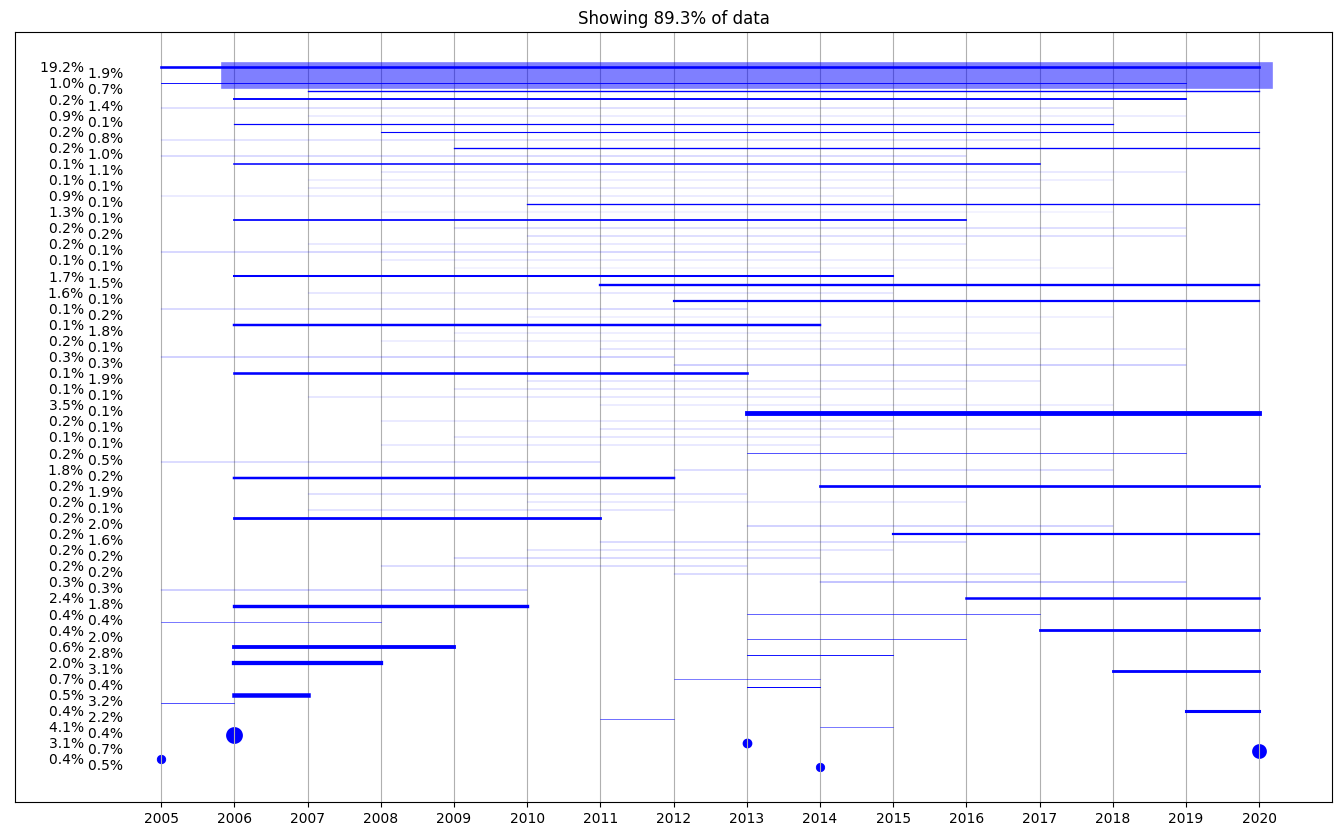

In [5]:
plot_time_range(df=df_fundam_final[df_fundam_final['consec_year_group'] != -1],
                gr_by=['gvkey', 'consec_year_group'], time_var='fyear', label_space=10)

# Replicate paper

*Predicting Future Earnings Changes Using Machine Learning and Detailed Financial Data*  https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12429

### Remove uninformative variables

In [5]:
FILE_NAME = 'df_paper'

# define dataset
df_work = (df_fundam_final[(~df_fundam_final['paper_period'].isna()) &
                           (df_fundam_final['consec_year_group'] != -1) &
                          (~df_fundam_final['LAG_index'].isna())]
          .drop(columns='fyear')
          .rename(columns={'paper_period_year': 'fyear'}))

# create features
df_work = make_features(df_work, df_original = df_fundam_final, thrsh_zeros = 0.3, file_name = FILE_NAME,
                        col_keep = ['main_index', 'fyear', 'EPS_change_next_yr', 'EPS_change_next_yr_detrend'], time_var = 'fyear',
                       CODING_TABLES_FOLDER=CODING_TABLES_FOLDER, STATS_FOLDER=STATS_FOLDER)

# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_work_stats = stats_with_description(df_work, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_work_stats.to_csv(os.path.join(STATS_FOLDER, '01a_' + FILE_NAME + '_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '01a_' + FILE_NAME + '_stats.csv'))




- Replacing missing values with zeros

- Removed columns because percentage of zeros is above 30.0 %: 385

- List of variables and percentages saved to .\Stats\01_df_paper_removed_col.csv
- Remaining columns: 135

- Evaluating lagged variables

- Evaluating percentage change
- Replacing NaN and Inf with zeros

- Normalizing by Total Asset
- Replacing Inf with zeros (some lagged total assets may be zero - only for oldest year available)

##### missing values found in:
   -EPS_change_next_yr_detrend: 3


,matched
2012.0,118
2013.0,1212
2014.0,1307
2015.0,1381
2016.0,1374
2017.0,1463
2018.0,1320
Total,8175



- Indices have been resetted

- Stats saved to .\Stats\01a_df_paper_stats.csv


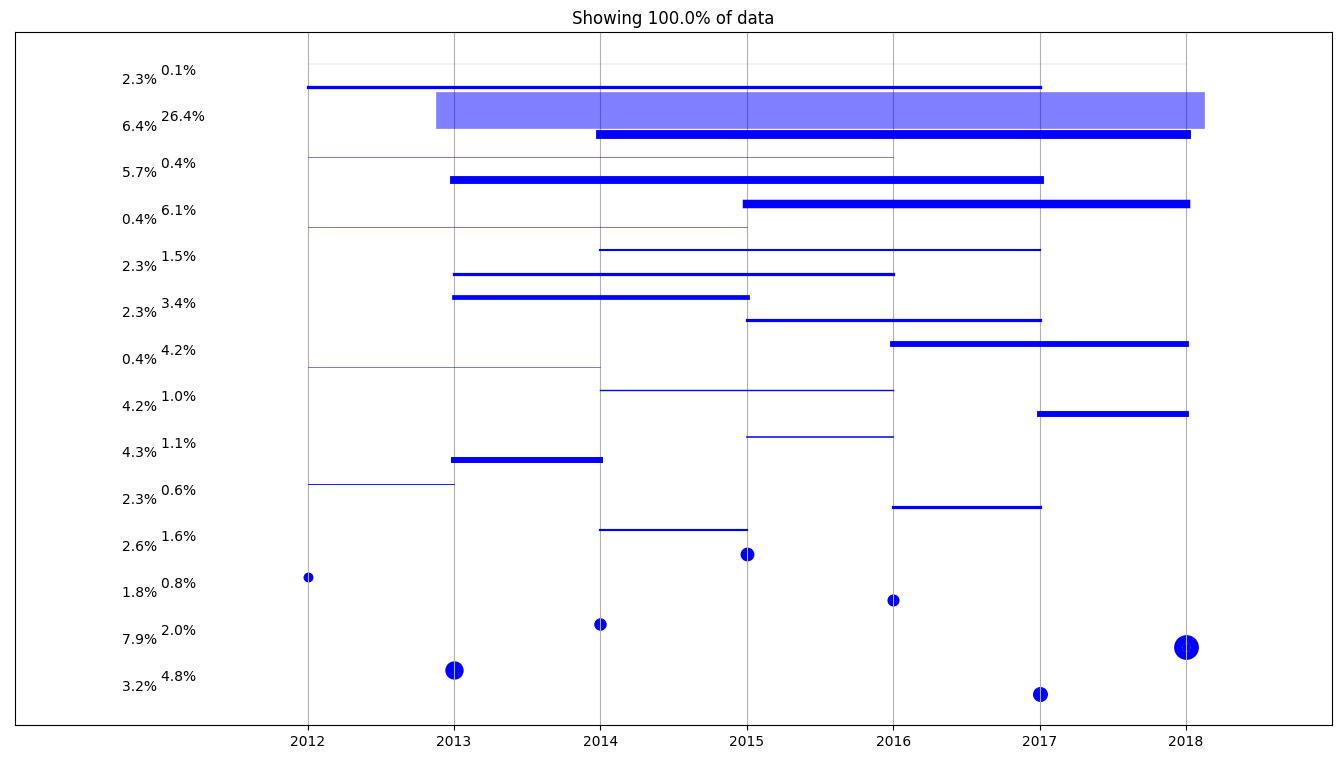

In [7]:
# check time interval

plot_time_range(df=(df_fundam_final.drop(columns=['fyear']).rename(columns={'paper_period_year': 'fyear'})
                    .merge(df_work[['main_index']].assign(cc = lambda x: 1), on='main_index', how='left')
                    .query('cc == 1')),
                gr_by=['gvkey', 'consec_year_group'], time_var='fyear', label_space=10, df_with_lagged_var=True,
                min_obs=0, min_count=0, fig_size=(17, 9))

### Define dataset

In [6]:
# Define final dataset, convert to binary flag, winsorize and scale
df_pred = df_work.copy()
df_pred['fyear'] = df_pred['fyear'].astype(int)
df_pred.index=df_pred['main_index']
df_pred=df_pred.drop(columns=['EPS_change_next_yr_detrend', 'main_index']).rename(columns={'EPS_change_next_yr': 'y'})
df_pred['y'] = np.where(df_pred['y'] > 0, 1, 0)

# winsorize and scale
df_pred=winsorize_and_scale(df_pred, skip_cols=['fyear', 'y'])
# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_pred_stats = stats_with_description(df_pred, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'),
                                       lag_label='_lag1', pc_label='_pc')
df_pred_stats.to_csv(os.path.join(STATS_FOLDER, '01b_' + FILE_NAME + '_scaled_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '01b_' + FILE_NAME + '_scaled_stats.csv'))

display(df_pred.head(5))

display(df_pred['y'].value_counts().to_frame().reset_index().rename(columns={'index': 'flag', 'y': 'count'}).assign(
        perc = lambda x: np.round(x['count'] / x['count'].sum() * 100, 2)))

display(df_pred.groupby('fyear').agg(**{
    'Tot Obs': ('y', 'size'),
    '1': ('y', lambda x: str(sum(x == 1)) + ' (' + str(np.round(sum(x == 1) / len(x) * 100, 1)) +'%)' ),
    '0': ('y', lambda x: str(sum(x == 0)) + ' (' + str(np.round(sum(x == 0) / len(x) * 100, 1)) +'%)' )}))


- Stats saved to .\Stats\01b_df_paper_scaled_stats.csv


,fyear,y,oiadp,ibadj,citotal,csho,ivncf,lse,ci,ebit,ib,cshpri,ni,at,pi,ibcom,cibegni,niadj,seq,cshfd,dilavx,oancf,icapt,ibc,teq,xopr,ceq,fincf,chech,lt,epsfi,epspx,epsfx,bkvlps,che,ceql,ceqt,epspi,oprepsx,opeps,gp,cshi,sale,cogs,fopo,revt,ao,aoloch,rect,re,stkco,emp,ch,ap,lo,ebitda,txt,oibdp,ibmii,dpc,cshr,fopox,dp,reuna,cstk,ppent,capx,cstkcv,aox,txpd,txndb,nopi,aodo,caps,rectr,lco,capxv,xrent,intpn,loxdr,ppegt,dpact,ppeveb,mrc1,txndba,recch,txdi,txndbl,intan,acominc,mrc2,dpvieb,mrc3,xint,aco,nopio,mrct,mrc4,dltt,xsga,xpr,txdc,optosey,act,wcap,lct,optosby,spi,intano,optprcey,optprcby,txc,mrc5,acox,gdwl,optex,acodo,mrcta,lcox,dt,optprcwa,sstk,dltr,fiao,optexd,optprcex,txs,xacc,ivaco,dlc,am,tfva,optca,optprcca,txtubend,txtubbegin,txfed,oiadp_lag1,ibadj_lag1,citotal_lag1,csho_lag1,ivncf_lag1,lse_lag1,ci_lag1,ebit_lag1,ib_lag1,cshpri_lag1,ni_lag1,at_lag1,pi_lag1,ibcom_lag1,cibegni_lag1,niadj_lag1,seq_lag1,cshfd_lag1,dilavx_lag1,oancf_lag1,icapt_lag1,ibc_lag1,teq_lag1,xopr_lag1,ceq_lag1,fincf_lag1,chech_lag1,lt_lag1,epsfi_lag1,epspx_lag1,epsfx_lag1,bkvlps_lag1,che_lag1,ceql_lag1,ceqt_lag1,epspi_lag1,oprepsx_lag1,opeps_lag1,gp_lag1,cshi_lag1,sale_lag1,cogs_lag1,fopo_lag1,revt_lag1,ao_lag1,aoloch_lag1,rect_lag1,re_lag1,stkco_lag1,emp_lag1,ch_lag1,ap_lag1,lo_lag1,ebitda_lag1,txt_lag1,oibdp_lag1,ibmii_lag1,dpc_lag1,cshr_lag1,fopox_lag1,dp_lag1,reuna_lag1,cstk_lag1,ppent_lag1,capx_lag1,cstkcv_lag1,aox_lag1,txpd_lag1,txndb_lag1,nopi_lag1,aodo_lag1,caps_lag1,rectr_lag1,lco_lag1,capxv_lag1,xrent_lag1,intpn_lag1,loxdr_lag1,ppegt_lag1,dpact_lag1,ppeveb_lag1,mrc1_lag1,txndba_lag1,recch_lag1,txdi_lag1,txndbl_lag1,intan_lag1,acominc_lag1,mrc2_lag1,dpvieb_lag1,mrc3_lag1,xint_lag1,aco_lag1,nopio_lag1,mrct_lag1,mrc4_lag1,dltt_lag1,xsga_lag1,xpr_lag1,txdc_lag1,optosey_lag1,act_lag1,wcap_lag1,lct_lag1,optosby_lag1,spi_lag1,intano_lag1,optprcey_lag1,optprcby_lag1,txc_lag1,mrc5_lag1,acox_lag1,gdwl_lag1,optex_lag1,acodo_lag1,mrcta_lag1,lcox_lag1,dt_lag1,optprcwa_lag1,sstk_lag1,dltr_lag1,fiao_lag1,optexd_lag1,optprcex_lag1,txs_lag1,xacc_lag1,ivaco_lag1,dlc_lag1,am_lag1,tfva_lag1,optca_lag1,optprcca_lag1,txtubend_lag1,txtubbegin_lag1,txfed_lag1,oiadp_pc,ibadj_pc,citotal_pc,csho_pc,ivncf_pc,lse_pc,ci_pc,ebit_pc,ib_pc,cshpri_pc,ni_pc,at_pc,pi_pc,ibcom_pc,cibegni_pc,niadj_pc,seq_pc,cshfd_pc,dilavx_pc,oancf_pc,icapt_pc,ibc_pc,teq_pc,xopr_pc,ceq_pc,fincf_pc,chech_pc,lt_pc,epsfi_pc,epspx_pc,epsfx_pc,bkvlps_pc,che_pc,ceql_pc,ceqt_pc,epspi_pc,oprepsx_pc,opeps_pc,gp_pc,cshi_pc,sale_pc,cogs_pc,fopo_pc,revt_pc,ao_pc,aoloch_pc,rect_pc,re_pc,stkco_pc,emp_pc,ch_pc,ap_pc,lo_pc,ebitda_pc,txt_pc,oibdp_pc,ibmii_pc,dpc_pc,cshr_pc,fopox_pc,dp_pc,reuna_pc,cstk_pc,ppent_pc,capx_pc,cstkcv_pc,aox_pc,txpd_pc,txndb_pc,nopi_pc,aodo_pc,caps_pc,rectr_pc,lco_pc,capxv_pc,xrent_pc,intpn_pc,loxdr_pc,ppegt_pc,dpact_pc,ppeveb_pc,mrc1_pc,txndba_pc,recch_pc,txdi_pc,txndbl_pc,intan_pc,acominc_pc,mrc2_pc,dpvieb_pc,mrc3_pc,xint_pc,aco_pc,nopio_pc,mrct_pc,mrc4_pc,dltt_pc,xsga_pc,xpr_pc,txdc_pc,optosey_pc,act_pc,wcap_pc,lct_pc,optosby_pc,spi_pc,intano_pc,optprcey_pc,optprcby_pc,txc_pc,mrc5_pc,acox_pc,gdwl_pc,optex_pc,acodo_pc,mrcta_pc,lcox_pc,dt_pc,optprcwa_pc,sstk_pc,dltr_pc,fiao_pc,optexd_pc,optprcex_pc,txs_pc,xacc_pc,ivaco_pc,dlc_pc,am_pc,tfva_pc,optca_pc,optprcca_pc,txtubend_pc,txtubbegin_pc,txfed_pc
main_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,2015,1,0.045836,0.027737,0.030303,0.023934,-0.011719,1.0,0.030303,0.045836,0.028084,0.023854,0.033077,0.315900,0.041121,0.028084,0.033077,0.032730,0.600374,0.023993,0.027737,0.022259,0.694751,0.028084,0.600374,0.105797,0.600374,-0.026628,-0.016296,0.039963,0.009500,0.008044,0.008

,flag,count,perc
0,1,4660,57.0
1,0,3515,43.0


,Tot Obs,1,0
fyear,,,
2012,118,61 (51.7%),57 (48.3%)
2013,1212,706 (58.3%),506 (41.7%)
2014,1307,737 (56.4%),570 (43.6%)
2015,1381,690 (50.0%),691 (50.0%)
2016,1374,802 (58.4%),572 (41.6%)
2017,1463,835 (57.1%),628 (42.9%)
2018,1320,829 (62.8%),491 (37.2%)


### Tune ML models

In [7]:
TOT_TRIALS = 2
MEASURE = f1_score
CV_ITERATOR = customCV(n_train_years=2, n_test_years=1, rolling_wind_step=1, train_test_offset=0,
                       year_variable='fyear', back_ward=False, show_info=False)
OUT_OF_SAMPLE_YEARS = 1
TIME_VAR = 'fyear'
ADD_MEASURE = [roc_auc_score, accuracy_score, precision_score, recall_score]

In [ ]:
# loop over models

for mod in ['ElasticNet', 'RandomForest', 'GradientBoost']:
    
    print('#'*35, mod, '#'*35, '\n')
    _, _=tune_hyperparameters(df=df_pred, tot_trials=TOT_TRIALS, model_type=mod, measure=MEASURE, cv_iterator=CV_ITERATOR,
                              time_var=TIME_VAR, out_of_sample_years=OUT_OF_SAMPLE_YEARS, add_measure=ADD_MEASURE,
                              file_name=FILE_NAME, tuning_folder=TUNING_FOLDER,
                              tuning_checkpoint_folder=TUNING_CHECKPOINT_FOLDER)
    print('\n\n')

#################### ElasticNet ####################
Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_ElasticNet_f1_score.db 

- Started at: 04/12/2022 03:18:38 

Trial 2 / 2     avg elapsed time:  0:00:04
Total elapsed time: 0:00:16

- Pickle saved to .\Tuning\df_paper_ElasticNet_f1_score.pkl


Optimal score: 0.7130471495998876
Best params:
 {'alpha': 0.1, 'eta0': 0.02311675793819396, 'l1_ratio': 0.023236299238903912}


[W 2022-12-04 03:18:55,164] Param alpha unique value length is less than 2.


Param alpha unique value length is less than 2.


[W 2022-12-04 03:18:55,165] Param alpha unique value length is less than 2.


Param alpha unique value length is less than 2.


[W 2022-12-04 03:18:55,167] Param alpha unique value length is less than 2.


Param alpha unique value length is less than 2.


[W 2022-12-04 03:18:55,168] Param alpha unique value length is less than 2.


Param alpha unique value length is less than 2.

- Tuning log saved to .\Tuning\df_paper_ElasticNet_f1_score.csv



#################### RandomForest ####################
Split 1 Train: [2012 2013] (1330 obs)    Validation: [2014] (1307 obs)    Test: [2015] (1381 obs)
Split 2 Train: [2013 2014] (2519 obs)    Validation: [2015] (1381 obs)    Test: [2016] (1374 obs)
Split 3 Train: [2014 2015] (2688 obs)    Validation: [2016] (1374 obs)    Test: [2017] (1463 obs)
Split 4 Train: [2015 2016] (2755 obs)    Validation: [2017] (1463 obs)    Test: [2018] (1320 obs)


###### Reloading study: .\Tuning\df_paper_RandomForest_f1_score.db 

- Started at: 04/12/2022 03:18:57 

